# Exploring the idea of a Double-Wilson distribution

The structure factors of related structures are likely to be strongly correlated. We should be able to exploit this correlation during scaling and merging by constraining the optimization more strongly than by the requirement that structure factors following a Wilson distribution. 
The Wilson distribution derives from a model where each structure factor derives from a 1D (centric) or 2D (acentric) random walk on the real axis or the complex plane, as appropriate. The amplitudes thereof follow the Wilson distributions. A natural extension would be for the corresponding structure factors of two data sets to perform correlated random walks, resulting in a joint multivariate normal distribution of the real and complex components of the (complex) structure factors of the two data sets.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)
import numpy as np
import pandas as pd

In [2]:
import reciprocalspaceship as rs
from reciprocalspaceship.algorithms.scale_merged_intensities import mean_intensity_by_miller_index
import gemmi
import scipy

In [3]:
rs.__version__

'0.9.2'

In [4]:
path="double_wilson_data\\"

mtz1 = "5e1y_phases" # omit .mtz
mtz2 = "2vwr_phases"
ds1 = rs.read_mtz(path + mtz1 + ".mtz")
ds2 = rs.read_mtz(path + mtz2 + ".mtz")
print(ds1.cell)
print(ds2.cell)

ds1.info()

<gemmi.UnitCell(64.912, 39.288, 38.8, 90, 117.41, 90)>
<gemmi.UnitCell(63.773, 38.643, 38.186, 90, 117.22, 90)>
<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 35250 entries, (-56, 2, 16) to (51, 7, 0)
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype      
---  ------       --------------  -----      
 0   FREE         35250 non-null  MTZInt     
 1   FP           35250 non-null  SFAmplitude
 2   SIGFP        35250 non-null  Stddev     
 3   FC           35250 non-null  SFAmplitude
 4   PHIC         35250 non-null  Phase      
 5   FC_ALL       35250 non-null  SFAmplitude
 6   PHIC_ALL     35250 non-null  Phase      
 7   FWT          35250 non-null  SFAmplitude
 8   PHWT         35250 non-null  Phase      
 9   DELFWT       35250 non-null  SFAmplitude
 10  PHDELWT      35250 non-null  Phase      
 11  FOM          35250 non-null  Weight     
 12  FC_ALL_LS    35250 non-null  SFAmplitude
 13  PHIC_ALL_LS  35250 non-null  Phase      
dtypes: MTZInt(1), 

In [5]:
ds2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 19996 entries, (-47, 1, 12) to (43, 5, 0)
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype      
---  ------       --------------  -----      
 0   FREE         19996 non-null  MTZInt     
 1   FP           19996 non-null  SFAmplitude
 2   SIGFP        19996 non-null  Stddev     
 3   FC           19996 non-null  SFAmplitude
 4   PHIC         19996 non-null  Phase      
 5   FC_ALL       19996 non-null  SFAmplitude
 6   PHIC_ALL     19996 non-null  Phase      
 7   FWT          19996 non-null  SFAmplitude
 8   PHWT         19996 non-null  Phase      
 9   DELFWT       19996 non-null  SFAmplitude
 10  PHDELWT      19996 non-null  Phase      
 11  FOM          19996 non-null  Weight     
 12  FC_ALL_LS    19996 non-null  SFAmplitude
 13  PHIC_ALL_LS  19996 non-null  Phase      
dtypes: MTZInt(1), Phase(5), SFAmplitude(6), Stddev(1), Weight(1)
memory usage: 2.1 MB


#### Reciprocal lattice point coordinates
Let's calculate the reciprocal lattice point coordinates for each reflection.

In [6]:
def ds_add_rs(ds):
    """
    Adds three columns to an rs dataframe with the reciprocal space coordinates (in A^-1) for each Miller index
    """
    if not "rs_a" in ds.keys():
        orthomat_list  = ds.cell.orthogonalization_matrix.tolist()
        orthomat = np.asarray(orthomat_list)
    #
        hkl_array = np.asarray(list(ds.index.to_numpy()))
    #
        orthomat_inv_t = np.linalg.inv(orthomat).transpose()
        S = np.matmul(orthomat_inv_t, hkl_array.transpose())
    #    
        ds["rs_a"]=S.transpose()[:,0]
        ds["rs_b"]=S.transpose()[:,1]
        ds["rs_c"]=S.transpose()[:,2]
    else:
        pass
    return ds

Let's add them to the data frames.

In [7]:
ds_add_rs(ds1)
ds_add_rs(ds2)

FREE        FP     SIGFP         FC      PHIC    FC_ALL  PHIC_ALL  \
H   K L                                                                       
-47 1 12     1 53.521473 7.9036527   46.12001 248.23584 43.752834 248.22528   
      13     1  65.29443 3.4365492   68.54832 32.253178  65.03373 32.236435   
      14     1 51.549747  3.522566   47.22598  264.0694 44.798676  264.0872   
      15     1 26.032795  5.842344  17.350502  35.06216  16.44601 35.061054   
      16     1  28.69576  5.756335  29.129068 317.96762 27.562986 317.92725   
...        ...       ...       ...        ...       ...       ...       ...   
 42 6 0      1  20.17371 3.5902362 12.9703455 43.485977 12.220953  43.51586   
    8 0      1  79.85057  3.761697   82.18718 280.69757   77.0005  280.7024   
 43 1 0      1 17.786669 3.9335902  12.627776 320.73877  11.89779  320.6525   
    3 0      1 24.628624 3.4206424  25.180182  348.6264 23.658384  348.6401   
    5 0      1 26.683027 3.5919456  32.589516  34.54644 30.529564  34.54253   

               FWT      PHWT    DELFWT   PHDELWT        FOM  FC_ALL_LS  \
H   K L                                                                  
-47 1 12  60.00704 248.22528 16.254204  248.2253 0.96932936  46.115334   
      13 64.146484  32.23643 0.8872484  212.2367 0.98921305   68.53378   
      14 56.247925  264.0872 11.449248  264.0872  0.9800882  47.223164   
      15 28.216244 35.061054 11.770231 35.061058 0.85780746  17.349253   
      16 25.785973 317.92725 1.7770127 137.92734  0.9295617  29.113178   
...            ...       ...       ...       ...        ...        ...   
 42 6 0  21.298584  43.51586  9.077631 43.515865 0.83077276  12.977449   
    8 0  81.863716  280.7024  4.863221  280.7024 0.99475944  82.175285   
 43 1 0  16.397575 320.65253  4.499785 320.65253  0.7954093  12.643715   
    3 0  22.623163  348.6401 1.0352226 168.64015  0.9395886   25.17926   
    5 0  20.734657 34.542526  9.794908 214.54256 0.96061486  32.584015   

          PHIC_ALL_LS      rs_a      rs_b      rs_c  
H   K L                                              
-47 1 12    248.22583 -0.736989  0.025878 -0.025700  
      13    32.237293 -0.736989  0.025878  0.003749  
      14    264.08627 -0.736989  0.025878  0.033198  
      15    35.061108 -0.736989  0.025878  0.062647  
      16     317.9294 -0.736989  0.025878  0.092096  
...               ...       ...       ...       ...  
 42 6 0      43.51412  0.658586  0.155267  0.338758  
    8 0      280.7021  0.658586  0.207023  0.338758  
 43 1 0      320.6576  0.674267  0.025878  0.346824  
    3 0     348.63928  0.674267  0.077634  0.346824  
    5 0     34.542778  0.674267  0.129390  0.346824  

[19996 rows x 17 columns]

#### Combining data sets in a joint data frame
Let's combine ("merge" in pandas jargon) the data frames of the two datasets. We'll add the ratios of the observed structure factor amplitudes as columns. In a perfect world, we'd also make sure all the dtypes are what they should be.

In [8]:
ds1_2= ds1.merge(ds2, left_index=True, right_index=True, suffixes=("_1", "_2"))
ds1_2["gamma_pp"] = ds1_2["FP_2"]/ds1_2["FP_1"]
ds1_2.compute_dHKL(inplace=True)
ds1_2.label_centrics(inplace=True)
ds1_2.compute_multiplicity(inplace=True)
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 19664 entries, (-47, 1, 12) to (43, 5, 0)
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype      
---  ------         --------------  -----      
 0   FREE_1         19664 non-null  MTZInt     
 1   FP_1           19664 non-null  SFAmplitude
 2   SIGFP_1        19664 non-null  Stddev     
 3   FC_1           19664 non-null  SFAmplitude
 4   PHIC_1         19664 non-null  Phase      
 5   FC_ALL_1       19664 non-null  SFAmplitude
 6   PHIC_ALL_1     19664 non-null  Phase      
 7   FWT_1          19664 non-null  SFAmplitude
 8   PHWT_1         19664 non-null  Phase      
 9   DELFWT_1       19664 non-null  SFAmplitude
 10  PHDELWT_1      19664 non-null  Phase      
 11  FOM_1          19664 non-null  Weight     
 12  FC_ALL_LS_1    19664 non-null  SFAmplitude
 13  PHIC_ALL_LS_1  19664 non-null  Phase      
 14  rs_a_1         19664 non-null  float64    
 15  rs_b_1         19664 non-null  float64    
 16

Let's verify our calculation of reciprocal space coordinates.

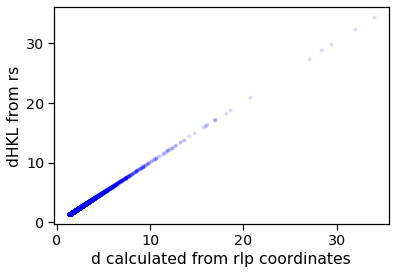

In [9]:
plt.plot(np.sqrt(1/(ds1_2["rs_a_2"]**2 +ds1_2["rs_b_2"]**2 +ds1_2["rs_c_2"]**2)), ds1_2["dHKL"],'b.',alpha=0.1)
plt.xlabel('d calculated from rlp coordinates'), plt.ylabel('dHKL from rs')
plt.show()

#### Reciprocal space (ASU) coverage
Let's see what chunk of reciprocal space these reflections are located in. I can't recall how I got this figure to be interactive.

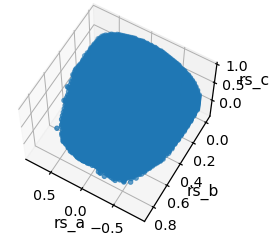

In [10]:
from mpl_toolkits import mplot3d

plt.ion
fig = plt.figure(figsize=(4,4))
ax = plt.axes(projection="3d")
ax.scatter3D(ds1["rs_a"], ds1["rs_b"], ds1["rs_c"])
ax.view_init(elev=60., azim=1200.)
ax.set_xlabel("rs_a")
ax.set_ylabel("rs_b")
ax.set_zlabel("rs_c")
plt.draw()

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)

## Anisotropic scaling

Let's start by setting a training set and test set. Because of the way the loss function below is constructed, we can just pass on entire data frames.

Anisotropic scaling seems to work well for very closely related data sets (e.g. different temperatures), but not for, e.g. apo/liganded pairs.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ds1_2, ds1_2, test_size=0.3, random_state=42)

Let's define our loss function. It also outputs corrected structure factors, if we want them.

In [12]:
def anisotropic_scaling_train_model(p, ds_a, ds_b,nargout=1):
    """
    Assumes rs dataframes with obtained from merging two data sets (in the pandas sense),
    First with keys FP_1, SIGFP_1, rs_a_1, rs_b_1, rs_c_1; second with keys FP_2, SIGFP_2.
    The first one is scaled to the second one with input parameters p such that 
    B = [[p0, p1, p2], [p1, p3, p4], [p2, p4, p5]].
    
    Returns an error-weighted residual.
    """
    
    rlp      = ds_a[["rs_a_1", "rs_b_1", "rs_c_1"]].to_numpy()
    
    B        = np.asarray([[p[0],p[1],p[2]],[p[1],p[3],p[4]],[p[2],p[4],p[5]]])
    B_corr   = np.exp(-np.sum(rlp * (B @ rlp.transpose()).transpose(),axis=1)).reshape(-1,1)
    
    FP_corr  = B_corr * ds_a["FP_1"].to_numpy().reshape(-1,1)
    residual = ds_b["FP_2"].to_numpy().reshape(-1,1) - FP_corr
    #print(FP_corr)
    
    err_a = ds_a["SIGFP_1"].to_numpy()
    err_b = ds_b["SIGFP_2"].to_numpy()
    quad_error = np.sqrt(err_a**2 + err_b**2)
    residual = residual/quad_error.reshape(-1,1)
    
    if nargout == 1:
        return residual.flatten()
    else:
        return residual.flatten(), FP_corr, B_corr

Next, we set up a robust nonlinear least-squares regression.

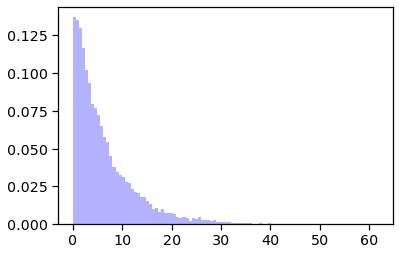

In [13]:
from scipy.optimize import least_squares
res_robust   = least_squares(anisotropic_scaling_train_model, [1,0,0,1,0,1], loss='cauchy', f_scale=1, args=(X_train, y_train))
# with a round of outlier rejection:
#res_robust_2 = least_squares(anisotropic_scaling_model, res_robust.x,  loss='soft_l1', f_scale=1, 
#                             args=(X_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)], 
#                                   y_train.loc[np.abs(res_robust.fun)<np.percentile(np.abs(res_robust.fun),98)]))
plt.hist(np.abs(res_robust.fun  ),100, alpha=0.3,color='b', density=True)
#plt.hist(np.abs(res_robust_2.fun),100, alpha=0.3,color='r', density=True)
plt.show()

We can extract the predicted ratios for the test set. We're using the loss function above for this purpose.

0.33742013692313483
Slope: 1.6818308022333828, intercept: -0.5035259918668884


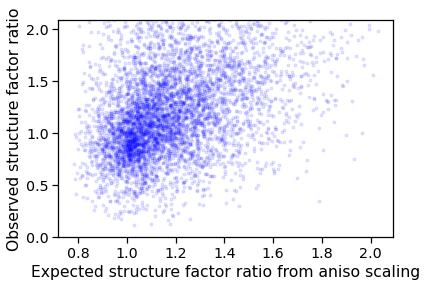

In [14]:
from sklearn.metrics import r2_score
test,  fp_corr,  B_corr = anisotropic_scaling_train_model(res_robust.x, X_test, y_test, nargout=3)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(B_corr.flatten(), y_test["gamma_pp"].to_numpy())
print(r_value)
print("Slope: " + str(slope) + ", intercept: " + str(intercept))

plt.plot(B_corr.flatten(), y_test["gamma_pp"].to_numpy(),'b.',alpha=0.1)
plt.xlabel('Expected structure factor ratio from aniso scaling')
plt.ylabel('Observed structure factor ratio')
plt.ylim((0,plt.xlim()[1]))
plt.show()

Adding the anisotropically scaled FP_1 and SIGFP_1 to the joint dataframe.

In [15]:
test2, fp_corr2, B_corr2 = anisotropic_scaling_train_model(res_robust.x, ds1_2, ds1_2, nargout=3)
ds1_2["FP_1_scaled"] = fp_corr2.flatten()
ds1_2["SIGFP_1_scaled"] = B_corr2.flatten() * ds1_2["SIGFP_1"]
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 19664 entries, (-47, 1, 12) to (43, 5, 0)
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype      
---  ------          --------------  -----      
 0   FREE_1          19664 non-null  MTZInt     
 1   FP_1            19664 non-null  SFAmplitude
 2   SIGFP_1         19664 non-null  Stddev     
 3   FC_1            19664 non-null  SFAmplitude
 4   PHIC_1          19664 non-null  Phase      
 5   FC_ALL_1        19664 non-null  SFAmplitude
 6   PHIC_ALL_1      19664 non-null  Phase      
 7   FWT_1           19664 non-null  SFAmplitude
 8   PHWT_1          19664 non-null  Phase      
 9   DELFWT_1        19664 non-null  SFAmplitude
 10  PHDELWT_1       19664 non-null  Phase      
 11  FOM_1           19664 non-null  Weight     
 12  FC_ALL_LS_1     19664 non-null  SFAmplitude
 13  PHIC_ALL_LS_1   19664 non-null  Phase      
 14  rs_a_1          19664 non-null  float64    
 15  rs_b_1          19664 non-nul

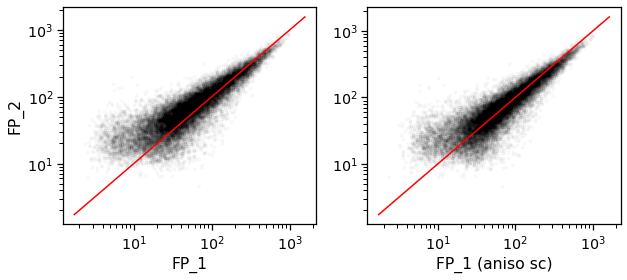

In [16]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["FP_1_scaled"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1 (aniso sc)")
plt.plot(plt.xlim(),plt.xlim(),'r-')

plt.show()

In [17]:
def compute_meanF_byres(ds, label="FP", nbins=20,sigma_cut=0, median=False):
    #print(ds.shape)
    if sigma_cut > 0:
        incl_criteria = ds[label].to_numpy().flatten() > sigma_cut * ds["SIG" + label].to_numpy().flatten()
        ds2 = ds[incl_criteria]
    else:
        ds2=ds
    
    ds2, bin_labels = ds2.assign_resolution_bins(bins=nbins)
    if median:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().median()))
        result = ds2.groupby("bin")[label].median()
    else:
        print("Average observations per bin: " + str(ds2["bin"].value_counts().mean()))
        result = ds2.groupby("bin")[label].mean()
    return result, bin_labels

def compute_cc(ds, labels=["F1","F2"], nbins=20):
    ds, bin_labels = ds.assign_resolution_bins(bins=nbins)
    print("Average observations per bin: " + str(ds["bin"].value_counts().mean()))
    g = ds.groupby("bin")[labels]
    result = g.corr(method="spearman").unstack().loc[:, (labels[0],labels[1])]
    return result, bin_labels

def plot_by_res_bin(result, bin_labels, ylabel=r"$CC_{1/2}$",color='b'):
    plt.plot(result, label="Data",color=color)
    plt.xticks(result.index, bin_labels, rotation=45, ha="right", rotation_mode="anchor")
    plt.ylabel(ylabel)
    plt.xlabel(r"Resolution Bin ($\AA$)")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylim(0, )
    plt.grid(linestyle='--')
    #plt.tight_layout()
    #plt.show()
    return

Let's examine the average SF amplitude by resolution.

Average observations per bin: 983.0
Average observations per bin: 983.0
Average observations per bin: 983.0


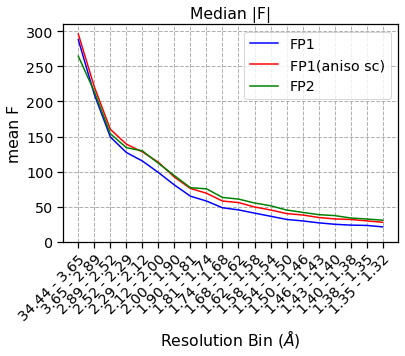

In [18]:
result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1", nbins=20,sigma_cut=0, median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='b')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_1_scaled", nbins=20,sigma_cut=0,median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='r')

result, bin_labels = compute_meanF_byres(ds1_2, label="FP_2", nbins=20,sigma_cut=0, median=True)
plot_by_res_bin(result, bin_labels, ylabel="mean F",color='g')

plt.title("Median |F|")
plt.legend(["FP1", "FP1(aniso sc)", "FP2"])
plt.ylim(0,)
plt.show()

Average observations per bin: 983.2
Average observations per bin: 983.2


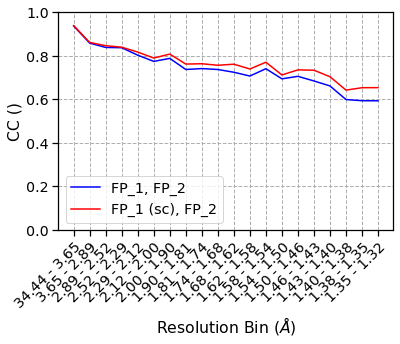

In [21]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
plot_by_res_bin(result_1, labels_1,)
plot_by_res_bin(result_2, labels_2,color='r')
plt.legend(["FP_1, FP_2", "FP_1 (sc), FP_2"])
plt.ylim(0,1)
plt.ylabel("CC ()")
plt.show()

#### Kernel ridge regression est of Sigma
We're estimating $<|F|^2>$ locally in reciprocal space! Because the expected intensity is the same for acentric and centric reflections, we can do this in one go for all of them.

By Rupp eq. (7-104): $ \Sigma_N = \left<I\right>/\varepsilon_h $

In [22]:
temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==True]
print("Distribution of multiplicities for centric reflections:")
print(temp.value_counts())
print("")

temp = ds1_2["EPSILON"][ds1_2["CENTRIC"].to_numpy()==False]
print("Distribution of multiplicities for acentric reflections:")
print(temp.value_counts())


Distribution of multiplicities for centric reflections:
2    843
Name: EPSILON, dtype: int64

Distribution of multiplicities for acentric reflections:
2    18808
4       13
Name: EPSILON, dtype: int64


Kernel ridge regression: see https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
default loss function is the MSE. GridsearchCV performs, by default, 5-fold cross-validation for each set of parameters. Because of this, we use the full data set.

In [23]:
# perhaps it's worth making this a method.
def sigma_cut_ds(ds, F_col="FP", sigF_col="SIGFP", sigma_cut=3):
    if sigma_cut > 0:
        incl_criteria = ds[F_col].to_numpy().flatten() > sigma_cut * ds[sigF_col].to_numpy().flatten()
        ds2 = ds[incl_criteria]
    else:
        ds2=ds
    return ds2

In [25]:
import os.path
from os import path as os_path
import pickle

if os_path.exists(path + mtz1 + "_krr.pkl") & os_path.exists(path + mtz2 + "_krr.pkl"):
    print("Strongly consider skipping the next cell! It takes 30-60 min")
    kr_1 = pickle.load(open(path + mtz1 + "_krr.pkl", 'rb'))
    kr_2 = pickle.load(open(path + mtz2 + "_krr.pkl", 'rb'))
else:
    print("No kernel ridge-regression has been performed yet!")

No kernel ridge-regression has been performed yet!


In [27]:
from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

# consider adding pre-processing
gridsearch = True # it takes up to an hour
# this will take a few minutes:
# GridsearchCV 
#   1st try   (alpha=1,  gamma=100, kernel='rbf'), with alpha and gamma at the top of the initial ranges.
#   2nd try   (alpha=10, gamma=100, kernel='rbf'), with alpha, but not gamma, at the top of the range
#   3rd try   (alpha=30, gamma=100, kernel='rbf'), with alpha in [10,30,100], gamma fixed.
# on 3rd try switched to neg_mean_absolute_error (from MSE)

if gridsearch: # for regression hyperparameter optimization -- needs some tweaking
    kr_1 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
                      param_grid={"alpha": [300, 100, 30, 10],
                                  "gamma": [300, 100, 30, 10]})
    kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
    kr_2 = GridSearchCV(KernelRidge(kernel='rbf'), scoring='neg_mean_absolute_error',
                      param_grid={"alpha": [300, 100, 30, 10],
                                  "gamma": [300, 100, 30, 10]})
    kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
else:
    # parameters tweaked for 2VWR and 5E1Y:
    kr_1 = KernelRidge(kernel='rbf', alpha=100, gamma=30)
    kr_2 = KernelRidge(kernel='rbf', alpha=100, gamma=30)
    kr_1.fit(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]], (ds1_2[["FP_1"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())
    kr_2.fit(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]], (ds1_2[["FP_2"]].to_numpy()**2)/ds1_2[["EPSILON"]].to_numpy())

pickle.dump(kr_1, open(path + mtz1 + "_krr.pkl",'wb'))
pickle.dump(kr_2, open(path + mtz2 + "_krr.pkl",'wb'))

In [28]:
if gridsearch:
    print(kr_1.best_estimator_)
    print(kr_2.best_estimator_)

KernelRidge(alpha=100, gamma=30, kernel='rbf')
KernelRidge(alpha=100, gamma=30, kernel='rbf')


#### Calculate normalized structure factors
Note: we've estimated $\Sigma$. To get normalized structure factors, $E_h=\frac{F_h}{\sqrt{\varepsilon \Sigma_h}}$, we need to do the following:

In [29]:
Sigma_kr_1 = kr_1.predict(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]])
Sigma_kr_2 = kr_2.predict(ds1_2[["rs_a_2", "rs_b_2", "rs_c_2"]])

In [30]:
E1    = ds1_2["FP_1"   ].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_1 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
E2    = ds1_2["FP_2"   ].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_2 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
SIGE1 = ds1_2["SIGFP_1"].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_1 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))
SIGE2 = ds1_2["SIGFP_2"].to_numpy().reshape(-1,1)/np.sqrt(Sigma_kr_2 * ds1_2["EPSILON"].to_numpy().reshape(-1,1))

ds1_2["EP_1"]    = E1.flatten()
ds1_2["EP_2"]    = E2.flatten()
ds1_2["SIGEP_1"] = SIGE1.flatten()
ds1_2["SIGEP_2"] = SIGE2.flatten()

Let's what, if anything, happened to the correlations per resolution shell.

Average observations per bin: 983.2
Average observations per bin: 983.2
Average observations per bin: 983.2


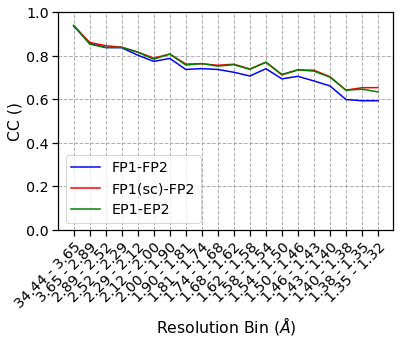

In [31]:
result_1, labels_1 = compute_cc(ds1_2,labels=["FP_1","FP_2"],nbins=20)
result_2, labels_2 = compute_cc(ds1_2,labels=["FP_1_scaled","FP_2"],nbins=20)
result_3, labels_3 = compute_cc(ds1_2,labels=["EP_1","EP_2"],nbins=20)
plot_by_res_bin(result_1, labels_1,)
plot_by_res_bin(result_2, labels_2,color='r')
plot_by_res_bin(result_3, labels_3,color='g')
plt.legend(["FP1-FP2", "FP1(sc)-FP2", "EP1-EP2"])
plt.ylim(0,1)
plt.ylabel("CC ()")
plt.show()

Normalization condenses the range of the structure factor amplitudes quite a bit.

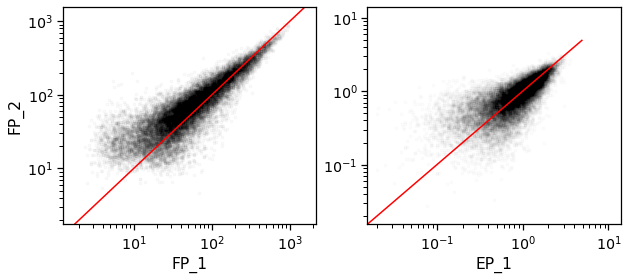

In [32]:
plt.figure(1,figsize=(10,4))
plt.subplot(1,2, 1)
plt.loglog(ds1_2["FP_1"], ds1_2["FP_2"],'k.',alpha=0.02)
plt.xlabel("FP_1"), plt.ylabel("FP_2")
xl=plt.xlim()
plt.ylim(xl)
plt.plot(xl,xl,'r-')

plt.subplot(1,2, 2)
plt.loglog(ds1_2["EP_1"], ds1_2["EP_2"],'k.',alpha=0.01)
plt.xlabel("EP_1")
xl2=plt.xlim()
plt.plot(xl2,xl2,'r-')
plt.xlim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.ylim((xl2[0],xl2[0]*xl[1]/xl[0])) # force to have the same range as the left panel
plt.show()

In [33]:
def wilson_dist_normalized(E, centric=False):
    if centric:
        P_E = np.sqrt(2/np.pi)*np.exp(-0.5*E**2) 
    else:
        P_E = 2*E*np.exp(-E**2)
    return P_E

Let's see how well the structure factor amplitudes fit the Wilson distributions.

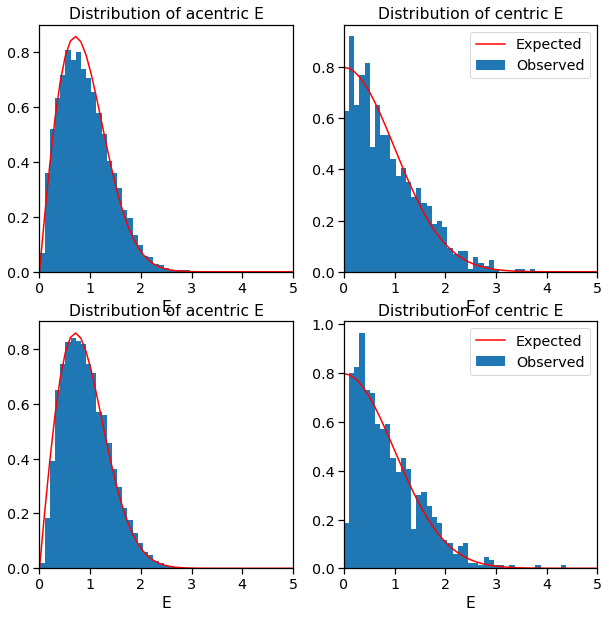

In [34]:
bins=np.linspace(0,5,50)

xl=(0,5)
plt.figure(1,figsize=(10,10))
plt.subplot(2,2, 1)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 2)
plt.hist(ds1_2["EP_1"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.subplot(2,2, 3)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==False],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=False),'r-')
plt.title("Distribution of acentric E")
plt.xlabel("E")
plt.xlim(xl)

plt.subplot(2,2, 4)
plt.hist(ds1_2["EP_2"][ds1_2["CENTRIC"].to_numpy()==True],bins=bins,density=True)
plt.plot(bins, wilson_dist_normalized(bins, centric=True),'r-')
plt.title("Distribution of centric E")
plt.xlabel("E")
plt.legend(["Expected","Observed"])
plt.xlim(xl)

plt.show()

Interpretation: The deviations at low E seem to be attributable to weak reflections tending to be systematically excluded from the data (verify!), and/or an artefact from FW. **Do we have a good way to make a plot of completeness v resolution?**. 

## Conditional PDFs for normalized structure factors

In [35]:
from scipy.stats import rice
from scipy.stats import foldnorm

### Now the same steps for real data

#### c. Means per bin for $|E_1|$, determined separately for acentrics and centrics.
We will calculate the conditional distributions of $|E_2|$ per bin of $|E_1|$. We'll set bin labels for both centrics and acentrics here:

In [37]:
cdf_bins = np.linspace(0,100,nbin+1)

ds1_2_centric  = (ds1_2["CENTRIC"].to_numpy()==True)
ds1_2_acentric = (ds1_2["CENTRIC"].to_numpy()==False)

ep1_bins          = np.percentile(ds1_2["EP_1"][ds1_2_acentric], cdf_bins)
ep1_bins[-1]      = ep1_bins[-1]+1e-6                # to avoid omitting the largest data point
ep1_dig           = np.digitize(ds1_2["EP_1"][  ds1_2_acentric], ep1_bins) # note that we're creating bin labels for all reflections, acentric or not

ep1_cent_bins     = np.percentile(ds1_2["EP_1"][ds1_2_centric], cdf_bins)
ep1_cent_bins[-1] = ep1_cent_bins[-1]+1e-6
ep1_cent_dig      = np.digitize(ds1_2["EP_1"][  ds1_2_centric], ep1_cent_bins) # note that we're creating bin labels for all reflections, acentric or not

ds1_2["EP_1_bin"] = np.zeros((ds1_2["EP_1"].shape[0],1))
ds1_2["EP_1_bin"][ds1_2_acentric] = ep1_dig.flatten()
ds1_2["EP_1_bin"][ds1_2_centric ] = ep1_cent_dig.flatten()

C:\Program_Files_DH\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Program_Files_DH\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


Some inspection of the created bins!

Number of reflections per bin (acentric):
{1.0: 753, 2.0: 753, 3.0: 753, 4.0: 753, 5.0: 752, 6.0: 753, 7.0: 753, 8.0: 753, 9.0: 753, 10.0: 752, 11.0: 753, 12.0: 753, 13.0: 753, 14.0: 753, 15.0: 752, 16.0: 753, 17.0: 753, 18.0: 753, 19.0: 753, 20.0: 752, 21.0: 753, 22.0: 753, 23.0: 753, 24.0: 753, 25.0: 753}

Number of reflections per bin (centric):
{1.0: 34, 2.0: 34, 3.0: 34, 4.0: 33, 5.0: 34, 6.0: 34, 7.0: 33, 8.0: 34, 9.0: 34, 10.0: 33, 11.0: 34, 12.0: 34, 13.0: 33, 14.0: 34, 15.0: 34, 16.0: 33, 17.0: 34, 18.0: 34, 19.0: 33, 20.0: 34, 21.0: 34, 22.0: 33, 23.0: 34, 24.0: 34, 25.0: 34}


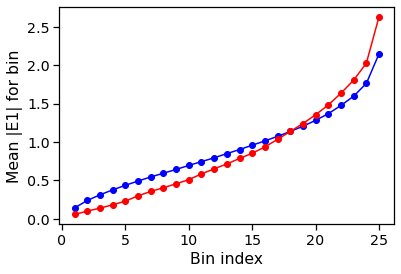

In [38]:
# For acentrics:
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_acentric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)
print()

# for centrics
unique, counts = np.unique(ds1_2["EP_1_bin"][ds1_2_centric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (centric):")
print(temp)

bin_means_acentric = ds1_2[ds1_2_acentric].groupby("EP_1_bin")["EP_1"].mean()
bin_means_centric  = ds1_2[ds1_2_centric ].groupby("EP_1_bin")["EP_1"].mean()
plt.plot(bin_means_acentric,'bo-')
plt.plot(bin_means_centric, 'ro-')
plt.xlabel("Bin index")
plt.ylabel("Mean |E1| for bin")
plt.show()

#### d. REAL DATA: Conditional distribution for Acentrics. Histograms of $|E_2|$ per bin of $|E_1|$.

C:\Program_Files_DH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


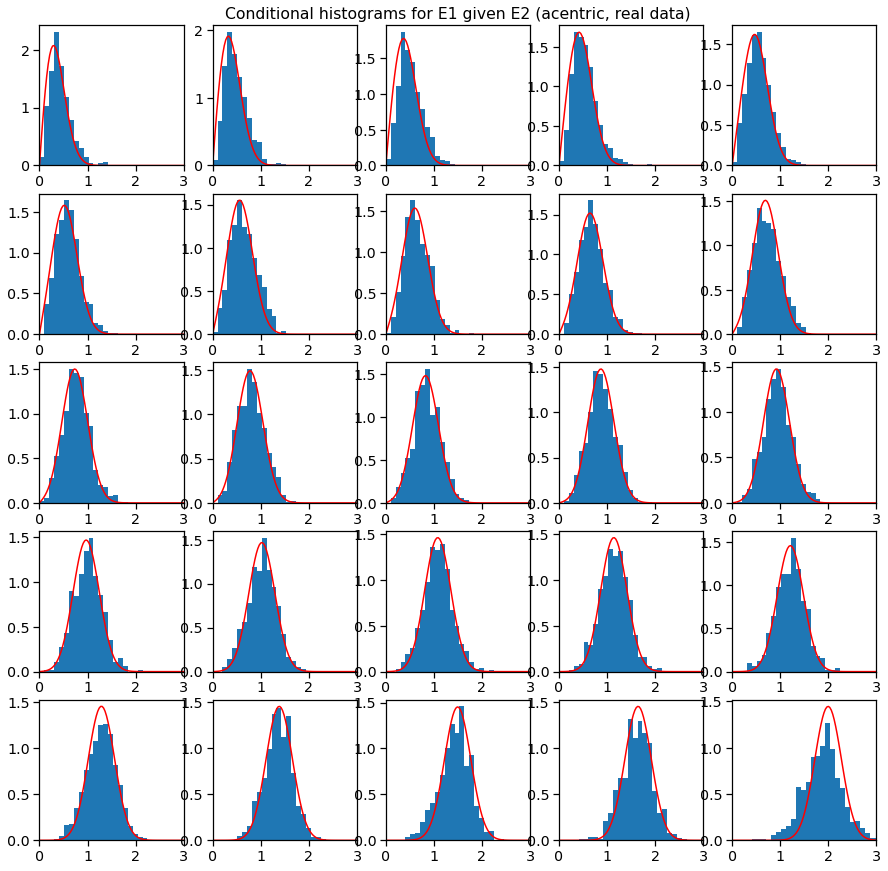

In [41]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.92                      # a guess of the corr coef between data sets
    r1  = rho*bin_means_acentric[i]  # conditional exp value of E1 given E2
    cond_var = 0.5*(1-rho**2)        # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["EP_2"][(ds1_2["EP_1_bin"]==i) & ds1_2_acentric],np.linspace(0,5,50),density=True)
    plt.plot(x, rice.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (acentric, real data)")
plt.show()
# Basic check:
#    plt.plot(np.sqrt((1-rho**2)+rho**2 * bin_means[i]**2), np.sqrt(np.mean(ds_test["EP_2"][ds_test["EP_1_bin"]==i]**2)), 'bo')

#### e. REAL DATA: Conditional distribution for Centrics. Step 1: means per bin for $|E_1|$.

C:\Program_Files_DH\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


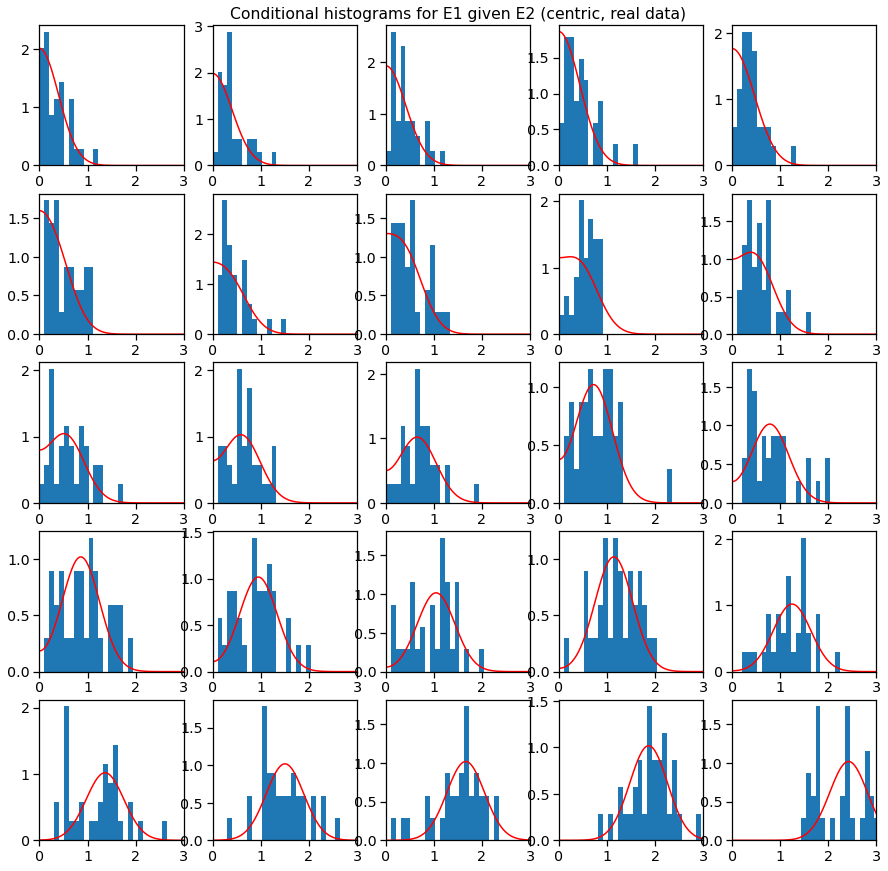

In [42]:
plt.figure(figsize=(15,15))
x=np.linspace(0,3,100)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.92                       # a guess of the corr coef between data sets
    r1  = rho*bin_means_centric[i]   # conditional exp value of E1 given E2
    cond_var = (1-rho**2)            # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["EP_2"][(ds1_2["EP_1_bin"]==i) & ds1_2_centric],np.linspace(0,5,50),density=True)
    plt.plot(x, foldnorm.pdf(x, r1/np.sqrt(cond_var), scale=np.sqrt(cond_var)),'r-')
    xl=[0,3] 
    plt.xlim(xl)

plt.subplot(5,5,3)
plt.title("Conditional histograms for E1 given E2 (centric, real data)")
plt.show()

### Let's take a look at phases!

In [43]:
ds1_2.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 19664 entries, (-47, 1, 12) to (43, 5, 0)
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype      
---  ------          --------------  -----      
 0   FREE_1          19664 non-null  MTZInt     
 1   FP_1            19664 non-null  SFAmplitude
 2   SIGFP_1         19664 non-null  Stddev     
 3   FC_1            19664 non-null  SFAmplitude
 4   PHIC_1          19664 non-null  Phase      
 5   FC_ALL_1        19664 non-null  SFAmplitude
 6   PHIC_ALL_1      19664 non-null  Phase      
 7   FWT_1           19664 non-null  SFAmplitude
 8   PHWT_1          19664 non-null  Phase      
 9   DELFWT_1        19664 non-null  SFAmplitude
 10  PHDELWT_1       19664 non-null  Phase      
 11  FOM_1           19664 non-null  Weight     
 12  FC_ALL_LS_1     19664 non-null  SFAmplitude
 13  PHIC_ALL_LS_1   19664 non-null  Phase      
 14  rs_a_1          19664 non-null  float64    
 15  rs_b_1          19664 non-nul

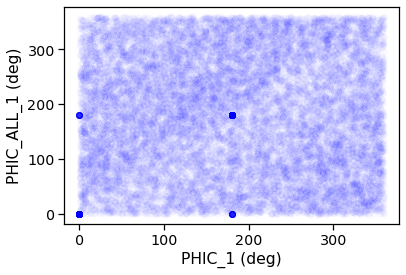

In [46]:
plt.plot(ds1_2["PHIC_1"].to_numpy(),ds1_2["PHIC_2"].to_numpy(),'bo',alpha=0.02)
plt.xlabel("PHIC_1 (deg)")
plt.ylabel("PHIC_ALL_1 (deg)")
plt.show()

I assume that the problem is that there is arbitrariness in the origin of the model.

Because of the structure of the Von Mises distribution, the conditional probability of the phase difference of E1 and E2 is a function only of E1 x E2. We'll bin by that. For now, we'll only think about acentrics.

Specifically, the Von Mises distribution (Bricogne, Methods in Enzymology, eq. 1.10) is given by:

$P\left( \varphi | R, r \right) = \frac{1}{2\pi I_0(z)}\exp\left( z \cos(\Delta \varphi)\right)$ 

with $z = \frac{2 r R}{(1-\rho^2)}$

which can also be derived by dividing eq. 14 for $P(R,\varphi | r)$ by eq. 15 for $P(R | r)$ in my current notes

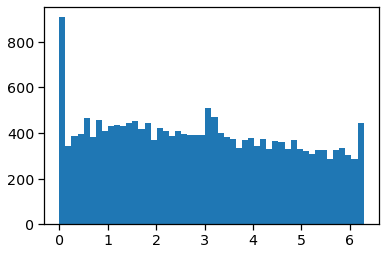

C:\Program_Files_DH\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of reflections per bin (acentric):
{1.0: 753, 2.0: 753, 3.0: 753, 4.0: 753, 5.0: 752, 6.0: 753, 7.0: 753, 8.0: 753, 9.0: 753, 10.0: 752, 11.0: 753, 12.0: 753, 13.0: 753, 14.0: 753, 15.0: 752, 16.0: 753, 17.0: 753, 18.0: 753, 19.0: 753, 20.0: 752, 21.0: 753, 22.0: 753, 23.0: 753, 24.0: 753, 25.0: 753}



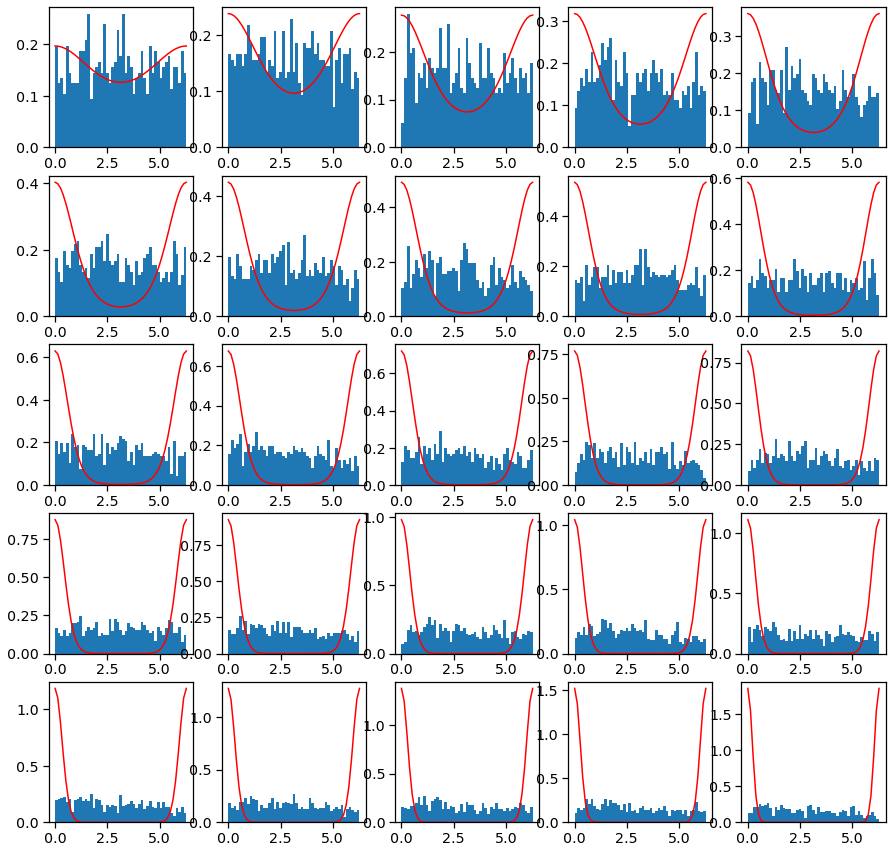

(18821,)
1
2
3
4
5
6
7
8
9
10
11
12
13
14


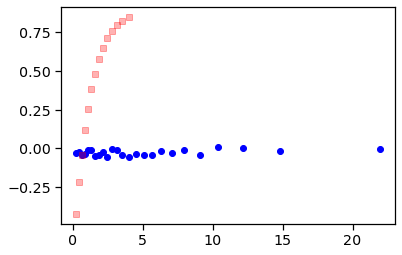

In [45]:
from scipy.stats import vonmises

ds1_2["DeltaPHIC"] = np.remainder((np.pi/180.0)*(ds1_2["PHIC_2"].to_numpy()-ds1_2["PHIC_1"].to_numpy()),2*np.pi)
ds1_2["cos(DeltaPHIC)"] = np.cos(ds1_2["DeltaPHIC"])

plt.hist(ds1_2["DeltaPHIC"],50 )
plt.show()

cdf_bins = np.linspace(0,100,nbin+1)

ds1_2["EP_12"]  = ds1_2["EP_1"] * ds1_2["EP_2"]                                 
ep12_bins       = np.percentile(ds1_2["EP_12"][ds1_2_acentric], cdf_bins)
ep12_bins[-1]   = ep12_bins[-1]+1e-6                # to avoid omitting the largest data point
ep12_dig        = np.digitize(ds1_2["EP_12"][  ds1_2_acentric], ep12_bins)

ds1_2["EP_12_bin"] = np.zeros((ds1_2["EP_12"].shape[0],1))
ds1_2["EP_12_bin"][ds1_2_acentric] = ep12_dig.flatten()

# For acentrics:
unique, counts = np.unique(ds1_2["EP_12_bin"][ds1_2_acentric], return_counts=True)
temp = dict(zip(unique, counts))
print("Number of reflections per bin (acentric):")
print(temp)
print()

bin_means_12_acentric = ds1_2[ds1_2_acentric].groupby("EP_12_bin")["EP_12"].mean()

                                 
plt.figure(figsize=(15,15))
x = np.linspace(0,2*np.pi,50)
for i in range(1,nbin+1):
    plt.subplot(5,5,i)
    rho = 0.78                         # a guess of the corr coef between data sets
    cond_var = 0.5*(1-rho**2)          # conditional variance  of E1 given E2
#    
    plt.hist(ds1_2["DeltaPHIC"][(ds1_2["EP_1_bin"]==i) & ds1_2_acentric],np.linspace(0,2*np.pi,50),density=True)
    plt.plot(x, vonmises.pdf(x, bin_means_12_acentric[i]/cond_var),'r-')

plt.show()

# THE FOLLOWING DOES NOT WORK YET. NOT SURE WHY.
print(ep1_dig.shape)
plt.plot(bin_means_12_acentric/cond_var, ds1_2["cos(DeltaPHIC)"][ds1_2_acentric].groupby(ds1_2["EP_12_bin"]).mean(),'bo')
for i in range(1,15):
    print(i)
    plt.plot(bin_means_12_acentric[i]/cond_var, 1-0.5*vonmises.var(bin_means_12_acentric[i]/cond_var),'rs',alpha=0.3)
plt.show()

### "Local scaling" (BELOW HAS NOT BEEN FINISHED).
We'll try to do a version of local scaling by learning a scale factor from reciprocal lattice point coordinates only.

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

sig_cut = 10
incl_criteria = (ds1_2["FP_1"]/ds1_2["SIGFP_1"]>sig_cut) & \
                (ds1_2["FP_2"]/ds1_2["SIGFP_2"]>sig_cut)
print("Number of retained reflections: " + str(np.sum(incl_criteria.to_numpy())) \
      + " out of " + str(incl_criteria.to_numpy().size))
X_train, X_test, y_train, y_test = train_test_split(ds1_2[["rs_a_1", "rs_b_1", "rs_c_1"]][incl_criteria], 
                                                    ds1_2["gamma_pp"][incl_criteria], 
                                                    test_size=0.3, random_state=42)

Let's train a neural network (MLP) and set some parameters using a cross-validation grid search. The results for (1BE9 & 1BFE) hit a ceiling that is similar using different parameter settings.

In [ ]:
parameters = {'alpha':[0.001],'hidden_layer_sizes':[(10,10), (5,5),(3,3,3)],'activation':['identity', 'logistic', 'tanh', 'relu']}
nn = MLPRegressor(max_iter=500)
reg = GridSearchCV(nn, parameters)
reg.fit(X_train, y_train)
print(sorted(reg.cv_results_.keys()))
#nn = MLPRegressor(
#    hidden_layer_sizes=(10,10),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
#    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
#    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
#    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

Let's check performance using the test set.

In [ ]:
print(reg.best_estimator_)
print(reg.best_score_)
print(reg.score(X_test, y_test))